## Three Stock Monte

This exercise tests your ability to retrieve stock price data using the Alpaca API and simulate multiple portfolio compositions using Monte Carlo Simulation.

### Import Dependencies

In [1]:
# Import libraries and dependencies
import os
import pandas as pd
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

### Get Past ~4 Year's Worth of Stock Price Data via Alpaca API Call

In [4]:
# Set timeframe to "1Day"
timeframe = "1Day"

# Set start and end datetimes between now and 4 years ago.
start_date = pd.Timestamp("2017-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-05-01", tz="America/New_York").isoformat()

# Set the ticker information
tickers = ["T","NKE","XOM"]

# Get 4 year's worth of historical price data
# HINT: Set "limit" to at least 10000 so all ticker rows are captured from get_bars()
df_ticker = api.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df


# Display sample data
df_ticker.head()

,close,high,low,trade_count,open,volume,vwap,symbol
timestamp,,,,,,,,
2017-05-01 04:00:00+00:00,54.99,55.45,54.98,30493,55.43,5361441,55.190028,NKE
2017-05-02 04:00:00+00:00,55.07,55.16,54.79,41590,55.12,7792518,54.974022,NKE
2017-05-03 04:00:00+00:00,54.53,55.30,54.40,48477,55.17,10746396,54.612038,NKE
2017-05-04 04:00:00+00:00,54.47,54.83,54.20,39262,54.68,7310669,54.501759,NKE
2017-05-05 04:00:00+00:00,53.95,54.50,53.56,57957,54.41,14261080,53.898559,NKE


> Note: We're going to simulate five years of growth below, and so we might want to pull at least five years of data in order to do that. But we pulled four because of Alpaca's rate limits--we can only pull 1,000 rows per ticker at a time (approximately four years of data, with 252 tradable days per year). If we pull data with repeated calls in a `for` loop, however, we can get quite a few more years than what we've got above.  

In [5]:
# Reorganize the DataFrame
# Separate ticker data
T = df_ticker[df_ticker["symbol"]=="T"].drop("symbol", axis=1)
NKE = df_ticker[df_ticker["symbol"]=="NKE"].drop("symbol", axis=1)
XOM = df_ticker[df_ticker["symbol"]=="XOM"].drop("symbol", axis=1)

# Concatenate the ticker DataFrames
df_ticker = pd.concat([T, NKE, XOM], axis=1, keys=["T","NKE","XOM"])

# Display sample data
df_ticker.head()

T                                             \
                           close   high    low trade_count   open    volume   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.10  39.70  39.06       95236  39.68  27137598   
2017-05-02 04:00:00+00:00  38.95  39.22  38.88       86239  39.14  26346738   
2017-05-03 04:00:00+00:00  38.40  38.98  38.15      113921  38.94  36621125   
2017-05-04 04:00:00+00:00  38.01  38.41  37.63      118192  38.41  32681751   
2017-05-05 04:00:00+00:00  38.56  38.71  38.03       82036  38.08  23262074   

                                        NKE                ...         \
                                vwap  close   high    low  ...   open   
timestamp                                                  ...          
2017-05-01 04:00:00+00:00  39.283136  54.99  55.45  54.98  ...  55.43   
2017-05-02 04:00:00+00:00  38.996146  55.07  55.16  54.79  ...  55.12   
2017-05-03 04:00:00+00:00  38.426498  54.53  55.30  54.40  ...  55.17   
2017-05-04 04:00:00+00:00  37.969998  54.47  54.83  54.20  ...  54.68   
2017-05-05 04:00:00+00:00  38.426797  53.95  54.50  53.56  ...  54.41   

                                                  XOM                  \
                             volume       vwap  close     high    low   
timestamp                                                               
2017-05-01 04:00:00+00:00   5361441  55.190028  82.06  82.2100  81.48   
2017-05-02 04:00:00+00:00   7792518  54.974022  82.05  82.5900  81.90   
2017-05-03 04:00:00+00:00  10746396  54.612038  82.70  83.0699  81.91   
2017-05-04 04:00:00+00:00   7310669  54.501759  81.64  82.3600  81.40   
2017-05-05 04:00:00+00:00  14261080  53.898559  82.02  82.2350  81.61   

                                                                   
                          trade_count   open    volume       vwap  
timestamp                                                          
2017-05-01 04:00:00+00:00       49225  81.51   9769374  81.945427  
2017-05-02 04:00:00+00:00       54236  82.14  10044837  82.185586  
2017-05-03 04:00:00+00:00       57309  81.95  11189766  82.631674  
2017-05-04 04:00:00+00:00       86290  82.29  17175853  81.728301  
2017-05-05 04:00:00+00:00       59390  81.64  11203370  81.940459  

[5 rows x 21 columns]

### Simulate five year portfolio growth with evenly-distributed stock investments

In [6]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns
MC_even_dist = MCSimulation(df_ticker, weights=[1/3,1/3,1/3], num_simulation=1000, num_trading_days=252*5)

# Print the simulation input data
MC_even_dist.portfolio_data.head()

T                                             \
                           close   high    low trade_count   open    volume   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.10  39.70  39.06       95236  39.68  27137598   
2017-05-02 04:00:00+00:00  38.95  39.22  38.88       86239  39.14  26346738   
2017-05-03 04:00:00+00:00  38.40  38.98  38.15      113921  38.94  36621125   
2017-05-04 04:00:00+00:00  38.01  38.41  37.63      118192  38.41  32681751   
2017-05-05 04:00:00+00:00  38.56  38.71  38.03       82036  38.08  23262074   

                                                     NKE         ...  \
                                vwap daily_return  close   high  ...   
timestamp                                                        ...   
2017-05-01 04:00:00+00:00  39.283136          NaN  54.99  55.45  ...   
2017-05-02 04:00:00+00:00  38.996146    -0.003836  55.07  55.16  ...   
2017-05-03 04:00:00+00:00  38.426498    -0.014121  54.53  55.30  ...   
2017-05-04 04:00:00+00:00  37.969998    -0.010156  54.47  54.83  ...   
2017-05-05 04:00:00+00:00  38.426797     0.014470  53.95  54.50  ...   

                                                     XOM                  \
                                vwap daily_return  close     high    low   
timestamp                                                                  
2017-05-01 04:00:00+00:00  55.190028          NaN  82.06  82.2100  81.48   
2017-05-02 04:00:00+00:00  54.974022     0.001455  82.05  82.5900  81.90   
2017-05-03 04:00:00+00:00  54.612038    -0.009806  82.70  83.0699  81.91   
2017-05-04 04:00:00+00:00  54.501759    -0.001100  81.64  82.3600  81.40   
2017-05-05 04:00:00+00:00  53.898559    -0.009547  82.02  82.2350  81.61   

                                                                                
                          trade_count   open    volume       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00       49225  81.51   9769374  81.945427          NaN  
2017-05-02 04:00:00+00:00       54236  82.14  10044837  82.185586    -0.000122  
2017-05-03 04:00:00+00:00       57309  81.95  11189766  82.631674     0.007922  
2017-05-04 04:00:00+00:00       86290  82.29  17175853  81.728301    -0.012817  
2017-05-05 04:00:00+00:00       59390  81.64  11203370  81.940459     0.004655  

[5 rows x 24 columns]

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 330.
Running Monte Carlo simulation number 340.
Running Monte Carlo simulation number 350.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 360.
Running Monte Carlo simulation number 370.
Running Monte Carlo simulation number 380.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 390.
Running Monte Carlo simulation number 400.
Running Monte Carlo simulation number 410.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 420.
Running Monte Carlo simulation number 430.
Running Monte Carlo simulation number 440.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 450.
Running Monte Carlo simulation number 460.
Running Monte Carlo simulation number 470.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 480.
Running Monte Carlo simulation number 490.
Running Monte Carlo simulation number 500.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 510.
Running Monte Carlo simulation number 520.
Running Monte Carlo simulation number 530.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 540.
Running Monte Carlo simulation number 550.
Running Monte Carlo simulation number 560.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 570.
Running Monte Carlo simulation number 580.
Running Monte Carlo simulation number 590.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 600.
Running Monte Carlo simulation number 610.
Running Monte Carlo simulation number 620.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 630.
Running Monte Carlo simulation number 640.
Running Monte Carlo simulation number 650.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 660.
Running Monte Carlo simulation number 670.
Running Monte Carlo simulation number 680.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 690.
Running Monte Carlo simulation number 700.
Running Monte Carlo simulation number 710.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 720.
Running Monte Carlo simulation number 730.
Running Monte Carlo simulation number 740.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 750.
Running Monte Carlo simulation number 760.
Running Monte Carlo simulation number 770.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 780.
Running Monte Carlo simulation number 790.
Running Monte Carlo simulation number 800.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 810.
Running Monte Carlo simulation number 820.
Running Monte Carlo simulation number 830.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 840.
Running Monte Carlo simulation number 850.
Running Monte Carlo simulation number 860.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 870.
Running Monte Carlo simulation number 880.
Running Monte Carlo simulation number 890.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 900.
Running Monte Carlo simulation number 910.
Running Monte Carlo simulation number 920.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 930.
Running Monte Carlo simulation number 940.
Running Monte Carlo simulation number 950.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 960.
Running Monte Carlo simulation number 970.
Running Monte Carlo simulation number 980.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 990.


<Axes: title={'center': '1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

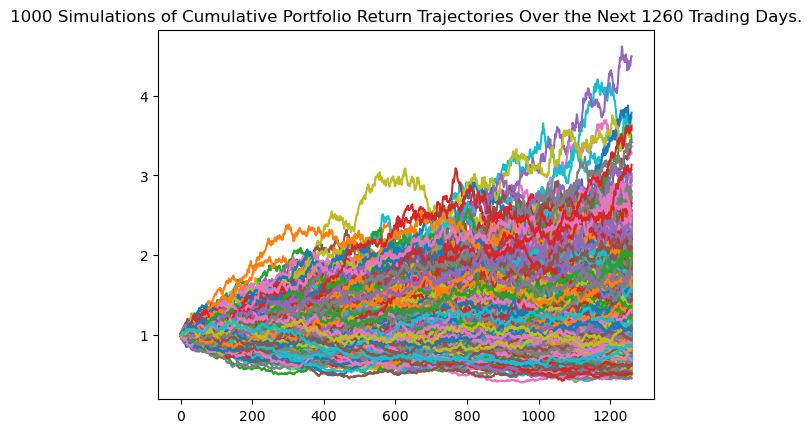

In [7]:
# Run a Monte Carlo simulation to forecast five years cumulative returns
MC_even_dist.plot_simulation()


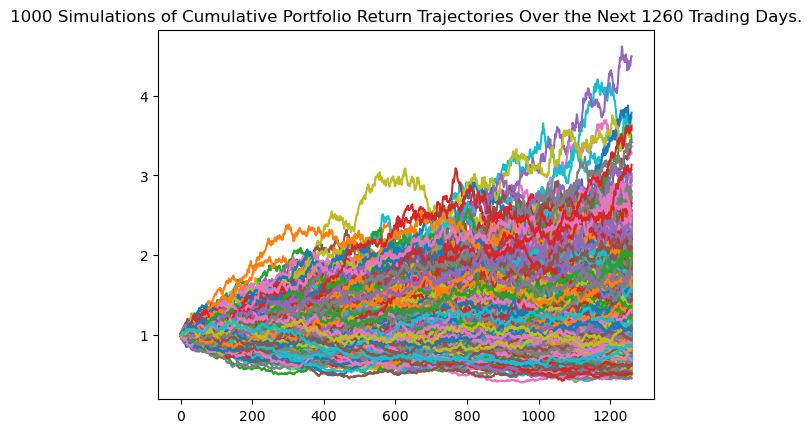

In [8]:
# Plot simulation outcomes
line_plot = MC_even_dist.plot_simulation()

line_plot.get_figure().savefig('MC_fiveyear_sim_plot.png', bbox_inches='tight')

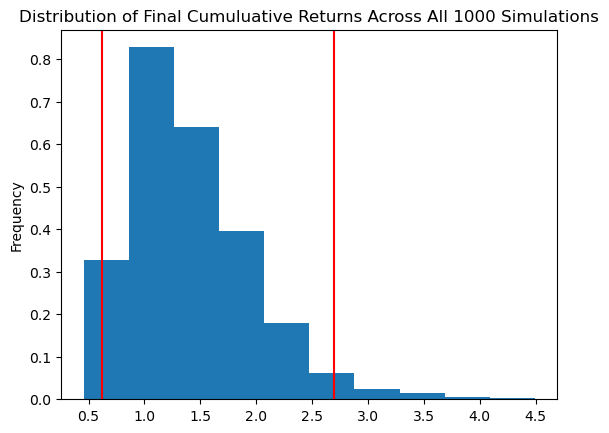

In [9]:
# Plot probability distribution and confidence intervals
dist_plot = MC_even_dist.plot_distribution()

dist_plot.get_figure().savefig('MC_fiveyear_dist_plot.png', bbox_inches = 'tight')

In [10]:
# Fetch summary statistics from the Monte Carlo simulation results
#MC_even_dist.summarize_cumulative_return()

# Print summary statistics


# Fetch summary statistics from the Monte Carlo simulation results
summary_metrics = MC_even_dist.simulated_return.iloc[-1].describe()
ci_series = MC_even_dist.confidence_interval
ci_series.index = ["95% CI Lower", "95% CI Upper"]

# Concatenate metrics and confidence interval series into a DataFrame
summary_df = pd.concat([summary_metrics, ci_series], axis=0)

# Print summary statistics with confidence intervals
print(summary_df)

count           1000.000000
mean               1.412883
std                0.553400
min                0.458489
25%                0.994353
50%                1.315830
75%                1.727764
max                4.492866
95% CI Lower       0.619745
95% CI Upper       2.691538
Name: 1260, dtype: float64


In [11]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments stocks
initial_investment = 15000
lower_bound = round((summary_df['95% CI Lower'] * initial_investment), 2)
upper_bound = round((summary_df['95% CI Upper'] * initial_investment), 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment}")
print(f"in the portofolio over the next 5 years will end within the range of ${lower_bound} and ${upper_bound}.")

sharpe = summary_df['mean']/summary_df['std']
print(f"this is your sharpe: {round(sharpe, 2)}, you make {round(sharpe,2)} units of return for every 1 unit of risk")

There is a 95% chance that an initial investment of $15000
in the portofolio over the next 5 years will end within the range of $9296.17 and $40373.07.
this is your sharpe: 2.55, you make 2.55 units of return for every 1 unit of risk


### Simulate five year portfolio growth with 60% AT&T stock

In [12]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 60% AT&T stock
MC_att = MCSimulation(df_ticker, weights=[.20,.60,.20], num_simulation=1000, num_trading_days=252*5)

# Print the simulation input data
MC_att.portfolio_data.head()

T                                             \
                           close   high    low trade_count   open    volume   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.10  39.70  39.06       95236  39.68  27137598   
2017-05-02 04:00:00+00:00  38.95  39.22  38.88       86239  39.14  26346738   
2017-05-03 04:00:00+00:00  38.40  38.98  38.15      113921  38.94  36621125   
2017-05-04 04:00:00+00:00  38.01  38.41  37.63      118192  38.41  32681751   
2017-05-05 04:00:00+00:00  38.56  38.71  38.03       82036  38.08  23262074   

                                                     NKE         ...  \
                                vwap daily_return  close   high  ...   
timestamp                                                        ...   
2017-05-01 04:00:00+00:00  39.283136          NaN  54.99  55.45  ...   
2017-05-02 04:00:00+00:00  38.996146    -0.003836  55.07  55.16  ...   
2017-05-03 04:00:00+00:00  38.426498    -0.014121  54.53  55.30  ...   
2017-05-04 04:00:00+00:00  37.969998    -0.010156  54.47  54.83  ...   
2017-05-05 04:00:00+00:00  38.426797     0.014470  53.95  54.50  ...   

                                                     XOM                  \
                                vwap daily_return  close     high    low   
timestamp                                                                  
2017-05-01 04:00:00+00:00  55.190028          NaN  82.06  82.2100  81.48   
2017-05-02 04:00:00+00:00  54.974022     0.001455  82.05  82.5900  81.90   
2017-05-03 04:00:00+00:00  54.612038    -0.009806  82.70  83.0699  81.91   
2017-05-04 04:00:00+00:00  54.501759    -0.001100  81.64  82.3600  81.40   
2017-05-05 04:00:00+00:00  53.898559    -0.009547  82.02  82.2350  81.61   

                                                                                
                          trade_count   open    volume       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00       49225  81.51   9769374  81.945427          NaN  
2017-05-02 04:00:00+00:00       54236  82.14  10044837  82.185586    -0.000122  
2017-05-03 04:00:00+00:00       57309  81.95  11189766  82.631674     0.007922  
2017-05-04 04:00:00+00:00       86290  82.29  17175853  81.728301    -0.012817  
2017-05-05 04:00:00+00:00       59390  81.64  11203370  81.940459     0.004655  

[5 rows x 24 columns]

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 330.
Running Monte Carlo simulation number 340.
Running Monte Carlo simulation number 350.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 360.
Running Monte Carlo simulation number 370.
Running Monte Carlo simulation number 380.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 390.
Running Monte Carlo simulation number 400.
Running Monte Carlo simulation number 410.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 420.
Running Monte Carlo simulation number 430.
Running Monte Carlo simulation number 440.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 450.
Running Monte Carlo simulation number 460.
Running Monte Carlo simulation number 470.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 480.
Running Monte Carlo simulation number 490.
Running Monte Carlo simulation number 500.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 510.
Running Monte Carlo simulation number 520.
Running Monte Carlo simulation number 530.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 540.
Running Monte Carlo simulation number 550.
Running Monte Carlo simulation number 560.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 570.
Running Monte Carlo simulation number 580.
Running Monte Carlo simulation number 590.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 600.
Running Monte Carlo simulation number 610.
Running Monte Carlo simulation number 620.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 630.
Running Monte Carlo simulation number 640.
Running Monte Carlo simulation number 650.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 660.
Running Monte Carlo simulation number 670.
Running Monte Carlo simulation number 680.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 690.
Running Monte Carlo simulation number 700.
Running Monte Carlo simulation number 710.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 720.
Running Monte Carlo simulation number 730.
Running Monte Carlo simulation number 740.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 750.
Running Monte Carlo simulation number 760.
Running Monte Carlo simulation number 770.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 780.
Running Monte Carlo simulation number 790.
Running Monte Carlo simulation number 800.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 810.
Running Monte Carlo simulation number 820.
Running Monte Carlo simulation number 830.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 840.
Running Monte Carlo simulation number 850.
Running Monte Carlo simulation number 860.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 870.
Running Monte Carlo simulation number 880.
Running Monte Carlo simulation number 890.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 900.
Running Monte Carlo simulation number 910.
Running Monte Carlo simulation number 920.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 930.
Running Monte Carlo simulation number 940.
Running Monte Carlo simulation number 950.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 960.
Running Monte Carlo simulation number 970.
Running Monte Carlo simulation number 980.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 990.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

<Axes: title={'center': '1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

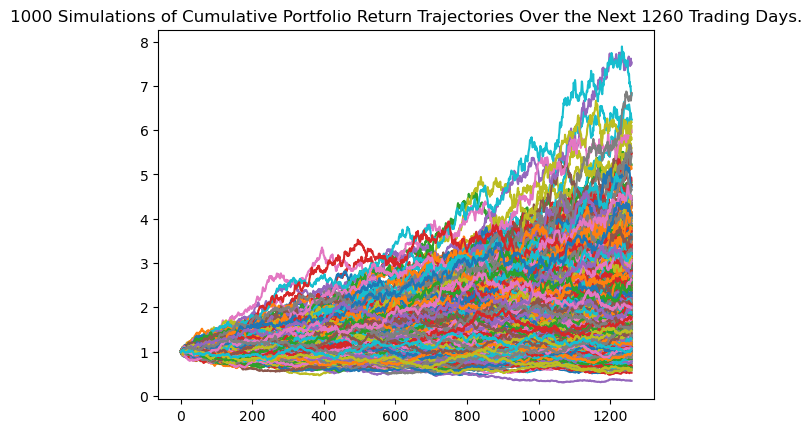

In [13]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% AT&T stock
MC_att.plot_simulation()

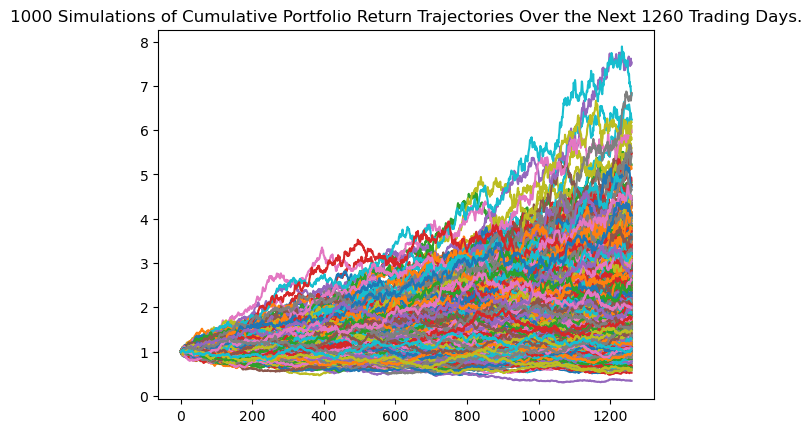

In [14]:
# Plot simulation outcomes
line_plot = MC_att.plot_simulation()

line_plot.get_figure().savefig('MC_ATT_fiveyear_sim_plot.png', bbox_inches='tight')

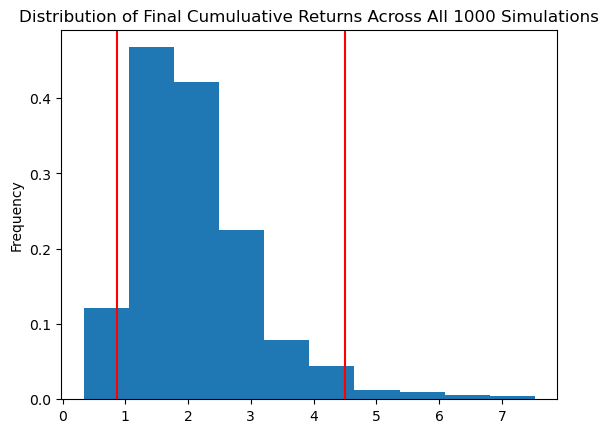

In [15]:
# Plot probability distribution and confidence intervals
dist_plot = MC_att.plot_distribution()

dist_plot.get_figure().savefig('MC_att_fiveyear_dist_plot.png', bbox_inches = 'tight')

In [16]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_metrics_att = MC_att.simulated_return.iloc[-1].describe()
ci_series_att = MC_att.confidence_interval
ci_series_att.index = ["95% CI Lower", "95% CI Upper"]

# Concatenate metrics and confidence interval series into a DataFrame
summary_df_att = pd.concat([summary_metrics_att, ci_series_att], axis=0)

# Print summary statistics with confidence intervals
print(summary_df_att)

count           1000.000000
mean               2.108963
std                0.977724
min                0.340293
25%                1.410388
50%                1.898668
75%                2.610871
max                7.526007
95% CI Lower       0.872518
95% CI Upper       4.494764
Name: 1260, dtype: float64


In [17]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
initial_investment = 15000
lower_bound_att = round((summary_df_att['95% CI Lower'] * initial_investment), 2)
upper_bound_att = round((summary_df_att['95% CI Upper'] * initial_investment), 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portofolio over the next 5 years will end within the range of ${lower_bound_att} and ${upper_bound_att}.")


There is a 95% chance that an initial investment of $15000 in the portofolio over the next 5 years will end within the range of $13087.76 and $67421.47.


### Simulate five year portfolio growth with 60% Exxon stock

In [18]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 60% Nike stock
MC_xom = MCSimulation(df_ticker, weights=[.20,.20,.60], num_simulation=1000, num_trading_days=252*5)

# Printing the simulation input data
MC_xom.portfolio_data.head()

T                                             \
                           close   high    low trade_count   open    volume   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.10  39.70  39.06       95236  39.68  27137598   
2017-05-02 04:00:00+00:00  38.95  39.22  38.88       86239  39.14  26346738   
2017-05-03 04:00:00+00:00  38.40  38.98  38.15      113921  38.94  36621125   
2017-05-04 04:00:00+00:00  38.01  38.41  37.63      118192  38.41  32681751   
2017-05-05 04:00:00+00:00  38.56  38.71  38.03       82036  38.08  23262074   

                                                     NKE         ...  \
                                vwap daily_return  close   high  ...   
timestamp                                                        ...   
2017-05-01 04:00:00+00:00  39.283136          NaN  54.99  55.45  ...   
2017-05-02 04:00:00+00:00  38.996146    -0.003836  55.07  55.16  ...   
2017-05-03 04:00:00+00:00  38.426498    -0.014121  54.53  55.30  ...   
2017-05-04 04:00:00+00:00  37.969998    -0.010156  54.47  54.83  ...   
2017-05-05 04:00:00+00:00  38.426797     0.014470  53.95  54.50  ...   

                                                     XOM                  \
                                vwap daily_return  close     high    low   
timestamp                                                                  
2017-05-01 04:00:00+00:00  55.190028          NaN  82.06  82.2100  81.48   
2017-05-02 04:00:00+00:00  54.974022     0.001455  82.05  82.5900  81.90   
2017-05-03 04:00:00+00:00  54.612038    -0.009806  82.70  83.0699  81.91   
2017-05-04 04:00:00+00:00  54.501759    -0.001100  81.64  82.3600  81.40   
2017-05-05 04:00:00+00:00  53.898559    -0.009547  82.02  82.2350  81.61   

                                                                                
                          trade_count   open    volume       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00       49225  81.51   9769374  81.945427          NaN  
2017-05-02 04:00:00+00:00       54236  82.14  10044837  82.185586    -0.000122  
2017-05-03 04:00:00+00:00       57309  81.95  11189766  82.631674     0.007922  
2017-05-04 04:00:00+00:00       86290  82.29  17175853  81.728301    -0.012817  
2017-05-05 04:00:00+00:00       59390  81.64  11203370  81.940459     0.004655  

[5 rows x 24 columns]

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 330.
Running Monte Carlo simulation number 340.
Running Monte Carlo simulation number 350.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 360.
Running Monte Carlo simulation number 370.
Running Monte Carlo simulation number 380.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 390.
Running Monte Carlo simulation number 400.
Running Monte Carlo simulation number 410.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 420.
Running Monte Carlo simulation number 430.
Running Monte Carlo simulation number 440.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 450.
Running Monte Carlo simulation number 460.
Running Monte Carlo simulation number 470.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 480.
Running Monte Carlo simulation number 490.
Running Monte Carlo simulation number 500.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 510.
Running Monte Carlo simulation number 520.
Running Monte Carlo simulation number 530.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 540.
Running Monte Carlo simulation number 550.
Running Monte Carlo simulation number 560.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 570.
Running Monte Carlo simulation number 580.
Running Monte Carlo simulation number 590.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 600.
Running Monte Carlo simulation number 610.
Running Monte Carlo simulation number 620.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 630.
Running Monte Carlo simulation number 640.
Running Monte Carlo simulation number 650.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 660.
Running Monte Carlo simulation number 670.
Running Monte Carlo simulation number 680.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 690.
Running Monte Carlo simulation number 700.
Running Monte Carlo simulation number 710.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 720.
Running Monte Carlo simulation number 730.
Running Monte Carlo simulation number 740.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 750.
Running Monte Carlo simulation number 760.
Running Monte Carlo simulation number 770.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 780.
Running Monte Carlo simulation number 790.
Running Monte Carlo simulation number 800.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 810.
Running Monte Carlo simulation number 820.
Running Monte Carlo simulation number 830.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 840.
Running Monte Carlo simulation number 850.
Running Monte Carlo simulation number 860.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 870.
Running Monte Carlo simulation number 880.
Running Monte Carlo simulation number 890.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 900.
Running Monte Carlo simulation number 910.
Running Monte Carlo simulation number 920.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 930.
Running Monte Carlo simulation number 940.
Running Monte Carlo simulation number 950.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 960.
Running Monte Carlo simulation number 970.
Running Monte Carlo simulation number 980.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 990.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


<Axes: title={'center': '1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

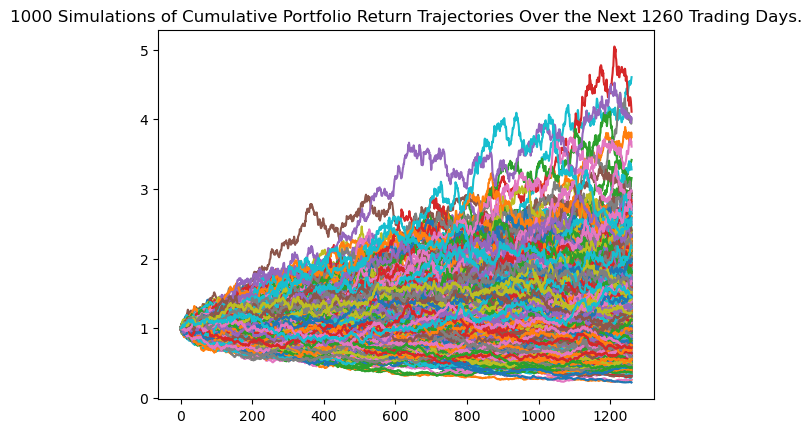

In [19]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% Exxon stock
MC_xom.plot_simulation()

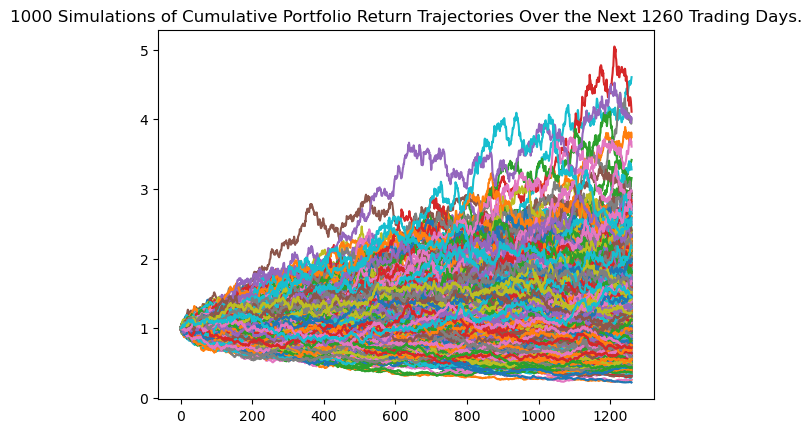

In [20]:
# Plot simulation outcomes
line_plot = MC_xom.plot_simulation()

line_plot.get_figure().savefig('MC_xom_fiveyear_sim_plot.png', bbox_inches='tight')

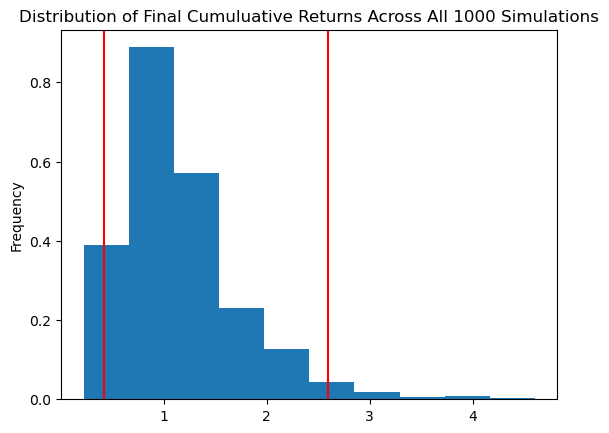

In [21]:
# Plot probability distribution and confidence intervals
dist_plot = MC_xom.plot_distribution()

dist_plot.get_figure().savefig('MC_nike_fiveyear_dist_plot.png', bbox_inches = 'tight')

In [22]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_metrics_xom = MC_xom.simulated_return.iloc[-1].describe()
ci_series_xom = MC_xom.confidence_interval
ci_series_xom.index = ["95% CI Lower", "95% CI Upper"]

# Concatenate metrics and confidence interval series into a DataFrame
summary_df_xom = pd.concat([summary_metrics_xom, ci_series_xom], axis=0)

# Print summary statistics with confidence intervals
print(summary_df_xom)

count           1000.000000
mean               1.149564
std                0.573598
min                0.224729
25%                0.751169
50%                1.016317
75%                1.384280
max                4.604132
95% CI Lower       0.421772
95% CI Upper       2.598167
Name: 1260, dtype: float64


In [23]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
initial_investment = 15000
lower_bound_xom = round((summary_df_xom['95% CI Lower'] * initial_investment), 2)
upper_bound_xom = round((summary_df_xom['95% CI Upper'] * initial_investment), 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portofolio over the next 5 years will end within the range of ${lower_bound_xom} and ${upper_bound_xom}.")

There is a 95% chance that an initial investment of $15000 in the portofolio over the next 5 years will end within the range of $6326.57 and $38972.5.


### Simulate five year portfolio growth with 60% Nike stock

In [24]:
# Configuring a Monte Carlo simulation to forecast five years cumulative returns
MC_nike = MCSimulation(df_ticker, weights=[.60,.20,.20], num_simulation=1000, num_trading_days=252*5)

# Print the simulation input data
MC_nike.portfolio_data.head()

T                                             \
                           close   high    low trade_count   open    volume   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.10  39.70  39.06       95236  39.68  27137598   
2017-05-02 04:00:00+00:00  38.95  39.22  38.88       86239  39.14  26346738   
2017-05-03 04:00:00+00:00  38.40  38.98  38.15      113921  38.94  36621125   
2017-05-04 04:00:00+00:00  38.01  38.41  37.63      118192  38.41  32681751   
2017-05-05 04:00:00+00:00  38.56  38.71  38.03       82036  38.08  23262074   

                                                     NKE         ...  \
                                vwap daily_return  close   high  ...   
timestamp                                                        ...   
2017-05-01 04:00:00+00:00  39.283136          NaN  54.99  55.45  ...   
2017-05-02 04:00:00+00:00  38.996146    -0.003836  55.07  55.16  ...   
2017-05-03 04:00:00+00:00  38.426498    -0.014121  54.53  55.30  ...   
2017-05-04 04:00:00+00:00  37.969998    -0.010156  54.47  54.83  ...   
2017-05-05 04:00:00+00:00  38.426797     0.014470  53.95  54.50  ...   

                                                     XOM                  \
                                vwap daily_return  close     high    low   
timestamp                                                                  
2017-05-01 04:00:00+00:00  55.190028          NaN  82.06  82.2100  81.48   
2017-05-02 04:00:00+00:00  54.974022     0.001455  82.05  82.5900  81.90   
2017-05-03 04:00:00+00:00  54.612038    -0.009806  82.70  83.0699  81.91   
2017-05-04 04:00:00+00:00  54.501759    -0.001100  81.64  82.3600  81.40   
2017-05-05 04:00:00+00:00  53.898559    -0.009547  82.02  82.2350  81.61   

                                                                                
                          trade_count   open    volume       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00       49225  81.51   9769374  81.945427          NaN  
2017-05-02 04:00:00+00:00       54236  82.14  10044837  82.185586    -0.000122  
2017-05-03 04:00:00+00:00       57309  81.95  11189766  82.631674     0.007922  
2017-05-04 04:00:00+00:00       86290  82.29  17175853  81.728301    -0.012817  
2017-05-05 04:00:00+00:00       59390  81.64  11203370  81.940459     0.004655  

[5 rows x 24 columns]

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Monte Carlo simulation number 340.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 350.
Running Monte Carlo simulation number 360.
Running Monte Carlo simulation number 370.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 380.
Running Monte Carlo simulation number 390.
Running Monte Carlo simulation number 400.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 410.
Running Monte Carlo simulation number 420.
Running Monte Carlo simulation number 430.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 440.
Running Monte Carlo simulation number 450.
Running Monte Carlo simulation number 460.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 470.
Running Monte Carlo simulation number 480.
Running Monte Carlo simulation number 490.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 500.
Running Monte Carlo simulation number 510.
Running Monte Carlo simulation number 520.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 530.
Running Monte Carlo simulation number 540.
Running Monte Carlo simulation number 550.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 560.
Running Monte Carlo simulation number 570.
Running Monte Carlo simulation number 580.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 590.
Running Monte Carlo simulation number 600.
Running Monte Carlo simulation number 610.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 620.
Running Monte Carlo simulation number 630.
Running Monte Carlo simulation number 640.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 650.
Running Monte Carlo simulation number 660.
Running Monte Carlo simulation number 670.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 680.
Running Monte Carlo simulation number 690.
Running Monte Carlo simulation number 700.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 710.
Running Monte Carlo simulation number 720.
Running Monte Carlo simulation number 730.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 740.
Running Monte Carlo simulation number 750.
Running Monte Carlo simulation number 760.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 770.
Running Monte Carlo simulation number 780.
Running Monte Carlo simulation number 790.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 800.
Running Monte Carlo simulation number 810.
Running Monte Carlo simulation number 820.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 830.
Running Monte Carlo simulation number 840.
Running Monte Carlo simulation number 850.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 860.
Running Monte Carlo simulation number 870.
Running Monte Carlo simulation number 880.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 890.
Running Monte Carlo simulation number 900.
Running Monte Carlo simulation number 910.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 920.
Running Monte Carlo simulation number 930.
Running Monte Carlo simulation number 940.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 950.
Running Monte Carlo simulation number 960.
Running Monte Carlo simulation number 970.


/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files and PDFs/Week 5 Class 3/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Activity Files 

Running Monte Carlo simulation number 980.
Running Monte Carlo simulation number 990.


<Axes: title={'center': '1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

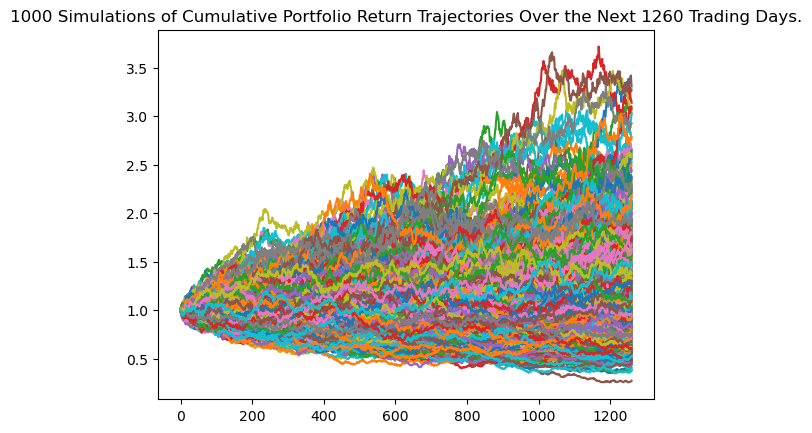

In [25]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% Exxon stock
MC_nike.plot_simulation()

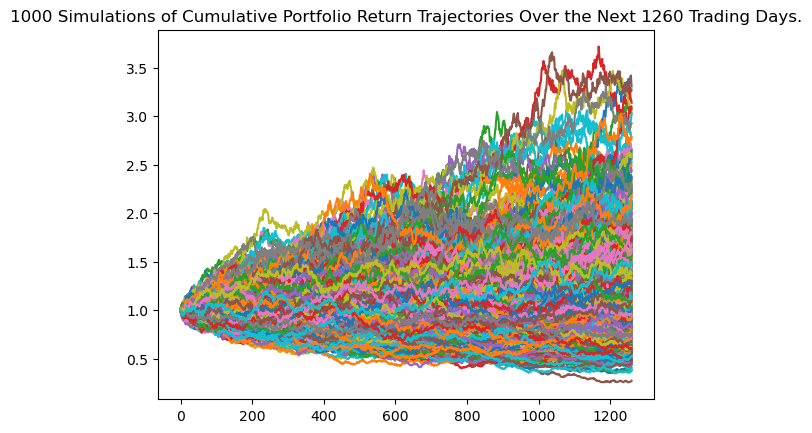

In [26]:
# Plot simulation outcomes
line_plot = MC_nike.plot_simulation()

line_plot.get_figure().savefig('MC_nike_fiveyear_sim_plot.png', bbox_inches='tight')

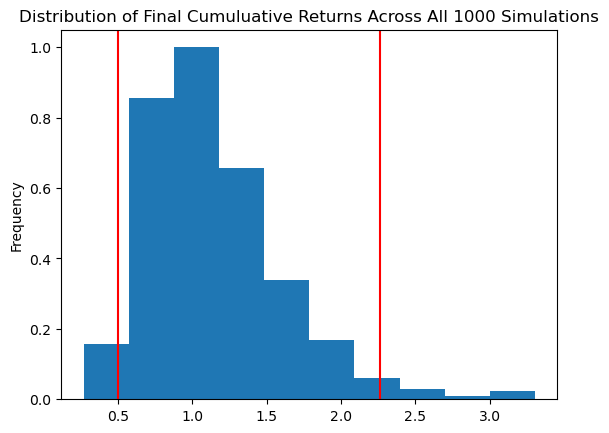

In [27]:
# Plot probability distribution and confidence intervals
dist_plot = MC_nike.plot_distribution()

dist_plot.get_figure().savefig('MC_nike_fiveyear_dist_plot.png', bbox_inches = 'tight')

In [28]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_metrics_nike = MC_nike.simulated_return.iloc[-1].describe()
ci_series_nike = MC_nike.confidence_interval
ci_series_nike.index = ["95% CI Lower", "95% CI Upper"]

# Concatenate metrics and confidence interval series into a DataFrame
summary_df_nike = pd.concat([summary_metrics_nike, ci_series_nike], axis=0)

# Print summary statistics with confidence intervals
print(summary_df_nike)

count           1000.000000
mean               1.147913
std                0.458136
min                0.272772
25%                0.824075
50%                1.051245
75%                1.377499
max                3.303920
95% CI Lower       0.503307
95% CI Upper       2.265121
Name: 1260, dtype: float64


In [29]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
initial_investment = 15000
lower_bound_nike = round((summary_df_nike['95% CI Lower'] * initial_investment), 2)
upper_bound_nike = round((summary_df_nike['95% CI Upper'] * initial_investment), 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portofolio over the next 5 years will end within the range of ${lower_bound_nike} and ${upper_bound_nike}.")

There is a 95% chance that an initial investment of $15000 in the portofolio over the next 5 years will end within the range of $7549.61 and $33976.81.


### Summarize findings across all 4 simulations

YOUR ANSWER HERE!

In [77]:
print(f"Initial Investment: ${initial_investment}")
print("--------------")
print(f'Upper and Lower Bounds of Equal Weighted: ${upper_bound} and ${lower_bound}')
print(f"Equal Weighted Max Profit: ${upper_bound - initial_investment}")
print(f"Equal Weighted Max Loss: $ {lower_bound - initial_investment}")
risk_reward_equal = round((upper_bound - initial_investment)/abs(lower_bound - initial_investment), 2)
print(f"Equal Weighted Risk-Reward Ratio: {risk_reward_equal}")
sharpe = summary_df['mean']/summary_df['std']
print(f"Equal Weighted Simulation Sharpe: {round(sharpe, 2)}")
risk_adjusted_efficiency_equal = round((risk_reward_equal / sharpe), 2)
print(f"Equal Weighted Risk-Adjusted Efficiency: {risk_adjusted_efficiency_equal}")
print("--------------")
print(f"Upper and Lower Bounds of Heavy ATT Weighted: ${upper_bound_att} and ${lower_bound_att}")
print(f"Heavy ATT Max Profit: ${upper_bound_att - initial_investment}")
print(f"Heavy ATT max loss: $ {lower_bound_att - initial_investment}")
risk_reward_att = round((upper_bound_att - initial_investment)/abs(lower_bound_att - initial_investment), 2)
print(f"Heavy ATT Risk-Reward Ratio: {risk_reward_att}")
sharpe_att = summary_df_att['mean']/summary_df_att['std']
print(f"Heavy ATT Simulation Sharpe: {round(sharpe_att, 2)}")
risk_adjusted_efficiency_att = round((risk_reward_att / sharpe_att), 2)
print(f"Heavy ATT Risk-Adjusted Efficiency: {risk_adjusted_efficiency_att}")
print("--------------")
print(f"Upper and Lower bounds of Heavy Exxon Weighted: ${upper_bound_xom} and ${lower_bound_xom}")
print(f"Heavy Exxon Max Profit: ${upper_bound_xom - initial_investment}")
print(f"Heavy Exxon Max Loss: $ {lower_bound_xom - initial_investment}")
risk_reward_xom = round((upper_bound_xom - initial_investment)/abs(lower_bound_xom - initial_investment), 2)
print(f"Heavy Exxon Risk-Reward Ratio: {risk_reward_xom}")
sharpe_xom = summary_df_xom['mean']/summary_df_xom['std']
print(f"Heavy Exxon Simulation Sharpe: {round(sharpe_xom, 2)}")
risk_adjusted_efficiency_xom = round((risk_reward_xom / sharpe_xom), 2)
print(f"Heavy Exxon Risk-Adjusted Efficiency: {risk_adjusted_efficiency_xom}")
print("--------------")
print(f"Upper and Lower Bounds of Heavy Nike Weighted: ${upper_bound_nike} and ${lower_bound_nike}")
print(f"Heavy Nike Max Profit: ${upper_bound_nike - initial_investment}")
print(f"Heavy Nike Max Loss: $ {lower_bound_nike - initial_investment}")
risk_reward_nike = round((upper_bound_nike - initial_investment)/abs(lower_bound_nike - initial_investment), 2)
print(f"Heavy Nike Risk-Reward Ratio: {risk_reward_nike}")
sharpe_nike = summary_df_nike['mean']/summary_df_nike['std']
print(f"Heavy Nike Simulation Sharpe: {round(sharpe_nike, 2)}")
risk_adjusted_efficiency_nike = round((risk_reward_nike / sharpe_nike), 2)
print(f"Heavy Nike Risk-Adjusted Efficiency: {risk_adjusted_efficiency_nike}")

Initial Investment: $15000
--------------
Upper and Lower Bounds of Equal Weighted: $40373.07 and $9296.17
Equal Weighted Max Profit: $25373.07
Equal Weighted Max Loss: $ -5703.83
Equal Weighted Risk-Reward Ratio: 4.45
Equal Weighted Simulation Sharpe: 2.55
Equal Weighted Risk-Adjusted Efficiency: 1.74
--------------
Upper and Lower Bounds of Heavy ATT Weighted: $67421.47 and $13087.76
Heavy ATT Max Profit: $52421.47
Heavy ATT max loss: $ -1912.2399999999998
Heavy ATT Risk-Reward Ratio: 27.41
Heavy ATT Simulation Sharpe: 2.16
Heavy ATT Risk-Adjusted Efficiency: 12.71
--------------
Upper and Lower bounds of Heavy Exxon Weighted: $38972.5 and $6326.57
Heavy Exxon Max Profit: $23972.5
Heavy Exxon Max Loss: $ -8673.43
Heavy Exxon Risk-Reward Ratio: 2.76
Heavy Exxon Simulation Sharpe: 2.0
Heavy Exxon Risk-Adjusted Efficiency: 1.38
--------------
Upper and Lower Bounds of Heavy Nike Weighted: $33976.81 and $7549.61
Heavy Nike Max Profit: $18976.809999999998
Heavy Nike Max Loss: $ -7450.39
H